This is a machine learning project that will create multiple ai models to classify stars, galaxies and qsos. The ai models will then be compared to each other to determine which one is the most accurate. 
To begin we will import the necessary libraries and then clean the dataset and transform it. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

# Scikit-learn imports
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import (
    train_test_split, cross_val_score, KFold, StratifiedKFold, LeaveOneOut, 
    cross_val_predict, GridSearchCV
)
from sklearn.metrics import (
    classification_report, f1_score, accuracy_score, confusion_matrix, 
    roc_curve, auc
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, mutual_info_classif
from sklearn.datasets import load_iris


<h1>Task 1</h1>

In [2]:
df = pd.read_csv('LightData.csv')
df.head()


,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237655e+18,167.861424,5.760343,17.66229,16.61391,16.15524,15.82759,15.64740,2125,301,6,327,9.402174e+17,GALAXY,0.049233,835,52326,331
1,1.237679e+18,6.749060,12.778837,23.64716,24.22103,21.74891,20.36495,20.00658,7773,301,4,354,6.969546e+18,GALAXY,0.686853,6190,56210,819
2,1.237664e+18,11.431416,-0.745963,21.89893,19.46076,18.15051,17.51659,17.14398,4263,301,2,192,1.272350e+18,STAR,0.000073,1130,52669,303
3,1.237666e+18,235.030509,22.953851,20.85096,20.29422,20.29779,20.02337,19.97873,4671,301,5,41,4.439628e+18,QSO,0.652301,3943,55336,744
4,1.237664e+18,27.606575,-0.370674,22.38297,21.65855,20.17187,19.33482,18.97131,4263,301,3,300,4.764862e+18,GALAXY,0.490334,4232,55447,195


In [3]:
missing_values = df.isnull().sum()
print(missing_values)

duplicate_rows = df[df.duplicated()]
print(f"Number of duplicate rows: {duplicate_rows.shape[0]}")


obj_ID         0
alpha          0
delta          0
u              0
g              0
r              0
i              0
z              0
run_ID         0
rerun_ID       0
cam_col        0
field_ID       0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
fiber_ID       0
dtype: int64
Number of duplicate rows: 0


There are no missing values or duplicate rows. This is good as now we dont need to deal with it by using the mean of a column or by removing duplicates etc.
Now lets start looking for outliers.

In [4]:
print(df.describe())

             obj_ID         alpha         delta             u             g  \
count  3.000000e+04  30000.000000  30000.000000  30000.000000  30000.000000   
mean   1.237665e+18    177.854835     24.175188     22.064520     20.611655   
std    8.422620e+12     96.275860     19.572728      2.253120      2.037770   
min    1.237646e+18      0.005528    -17.465391     10.996230     10.511390   
25%    1.237659e+18    127.968684      5.362152     20.318110     18.942440   
50%    1.237663e+18    181.198771     23.767485     22.157535     21.068300   
75%    1.237668e+18    233.766177     39.826093     23.681080     22.108270   
max    1.237681e+18    359.999031     82.947622     30.660390     31.602240   

                  r             i             z        run_ID  rerun_ID  \
count  30000.000000  30000.000000  30000.000000  30000.000000   30000.0   
mean      19.630073     19.071133     18.758505   4478.161067     301.0   
std        1.855496      1.759914      1.769115   1961.052394  

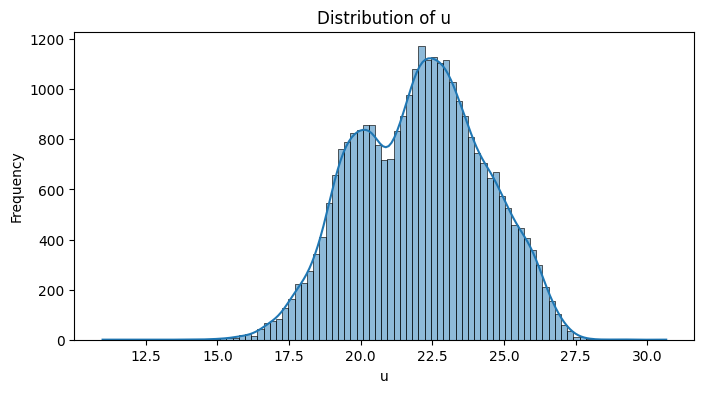

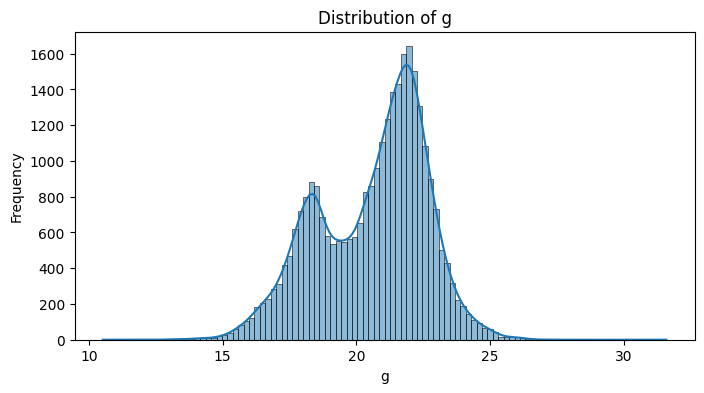

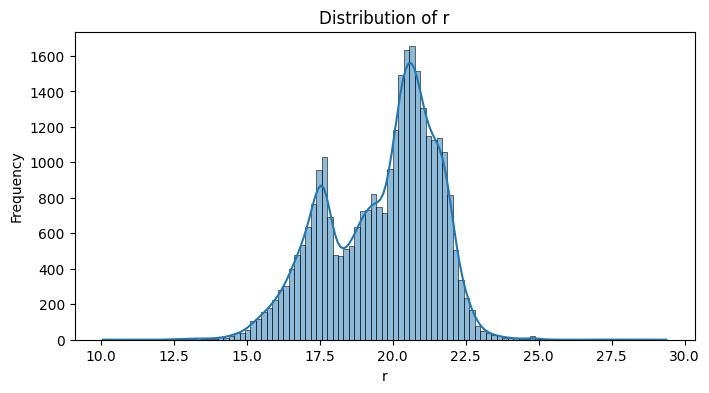

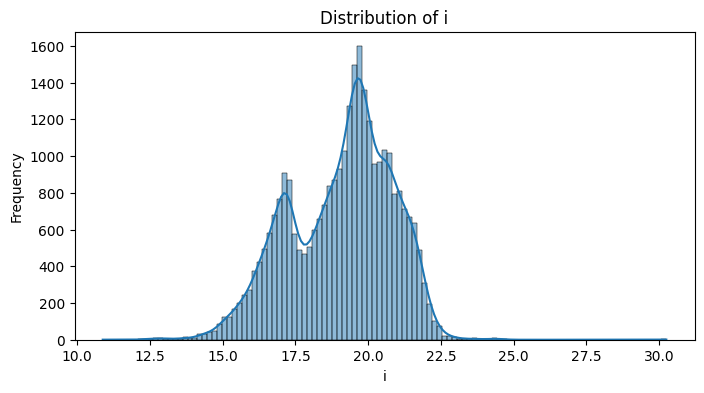

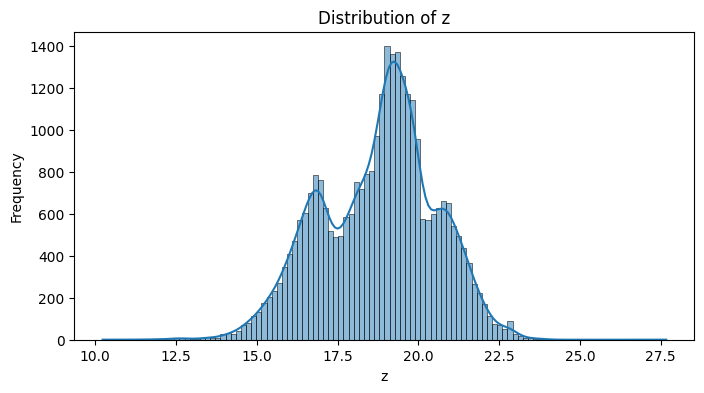

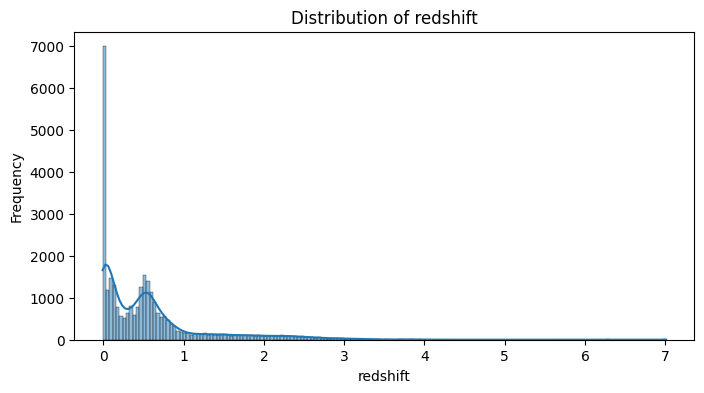

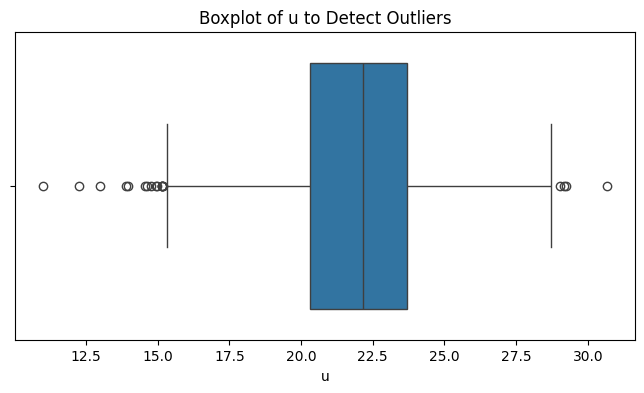

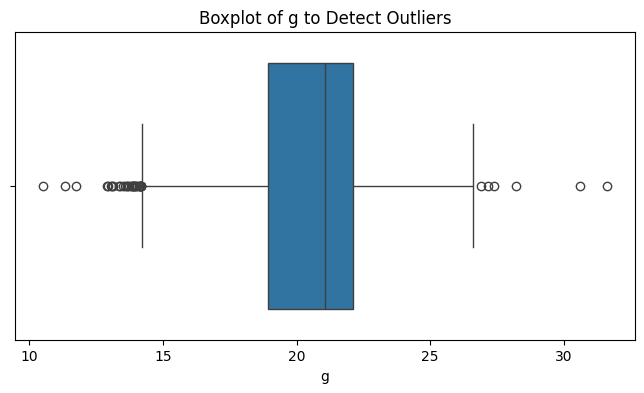

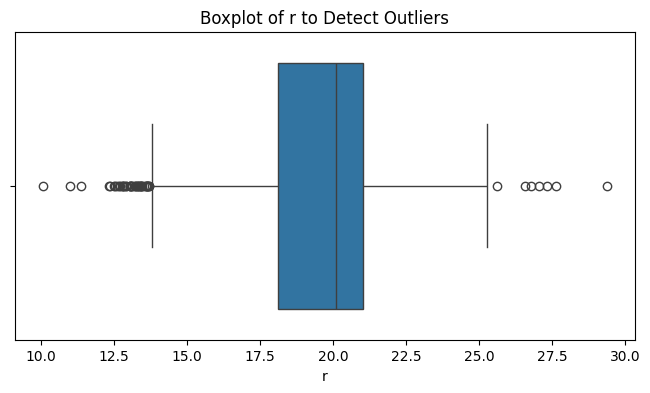

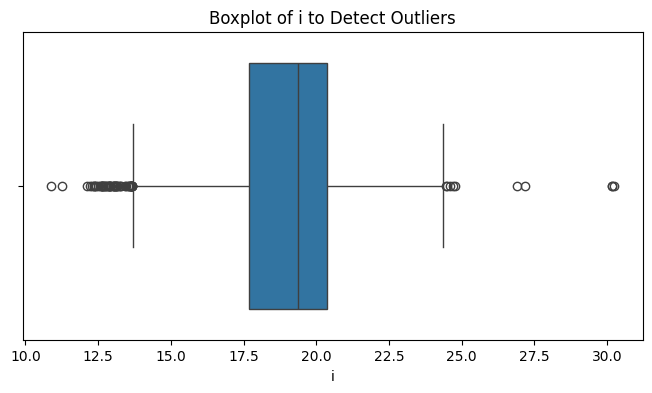

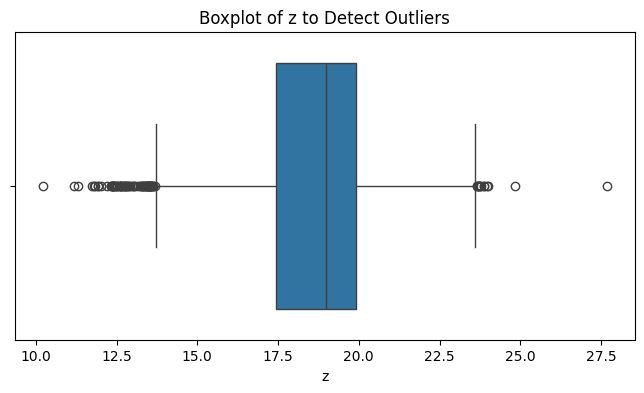

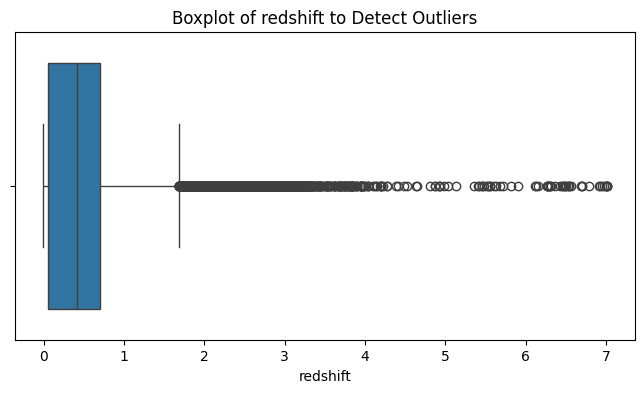

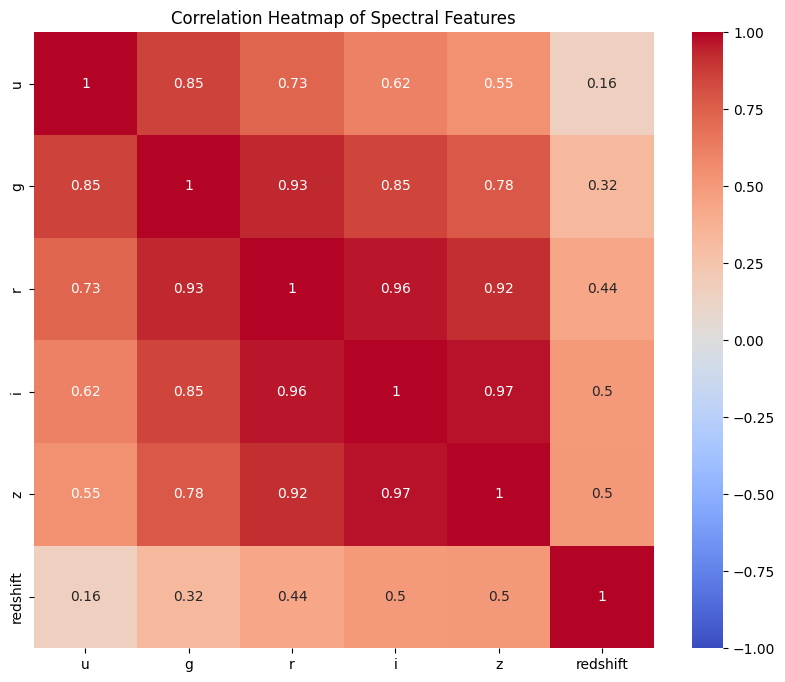


Outliers detected in u:
              obj_ID       alpha      delta         u         g         r  \
3018   1.237662e+18  166.316764  40.597296  15.16300  13.08427  12.58960   
5615   1.237665e+18  184.939948  29.612289  15.13130  13.34949  12.70526   
7337   1.237672e+18  203.951030   2.998922  15.16790  13.72197  12.92413   
8867   1.237679e+18   29.580557  20.463417  29.18637  20.05920  19.14478   
9304   1.237662e+18  164.342421  40.198571  14.98124  12.92272  12.49678   
10244  1.237666e+18   57.130548   0.771175  15.16132  15.48814  15.92196   
13163  1.237664e+18   19.689708  -1.058819  29.23438  25.40505  17.51251   
15742  1.237662e+18  239.423127  28.548438  12.26240  10.51139  10.06854   
15778  1.237662e+18  239.702668  27.467439  12.99664  11.33897  10.98255   
16703  1.237655e+18  208.360621   5.207759  14.93727  13.50754  12.89937   
17486  1.237650e+18  359.057135  55.901463  14.56906  13.06488  12.52759   
18368  1.237662e+18  166.089157  40.652210  15.14998  13.13317

In [5]:

spectral_columns = ['u', 'g', 'r', 'i', 'z', 'redshift']  

# visualising distributions
for column in spectral_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

# show boxplots for identifying outliers
for column in spectral_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column} to Detect Outliers')
    plt.xlabel(column)
    plt.show()

# Correlation heatmap to check relationships between features
plt.figure(figsize=(10, 8))
sns.heatmap(df[spectral_columns].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap of Spectral Features')
plt.show()

# Detecting outliers using the IQR method
outliers = {}
for column in spectral_columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    outlier_condition = (df[column] < (Q1 - 1.5 * IQR)) | (df[column] > (Q3 + 1.5 * IQR))
    outliers[column] = df[outlier_condition]
    print(f"\nOutliers detected in {column}:\n", outliers[column])

# Summarise
for column, outlier_data in outliers.items():
    print(f"{column}: {len(outlier_data)} outliers")


Okay so as you can see there are some outliers we need to deal with. We need to deal with them as they can introduce bias into our classification. 
I propose using logarithmic transformation or square root transformation to mitigate the effects of the outliers. 
Since the outliers for the redshift column are on the positive side we will use logarithmic transformation on that column.
For the other coloumns the outliers are mostly on the negative side so we will use the square root transformation for those columns.

Now we should investigate if they are real rare values or errors due to malfunctioning equipment/human error.
This might be outside the scope of our assignment. Theoretically speaking we could see other sources to check if values like the ones we have
have been reported before. Because if they are real rare values it might be worthwile keeping them.
I will assume they are real rare values due to some online reading ive done and because as I don't have access to the equipment records or cross reference materials to check values.
Also we will transform the columns so even if they are real it wont make too much of a difference.
Certain classification methods might be preferred here due to this uncertainty.

Anyways lets get transforming.


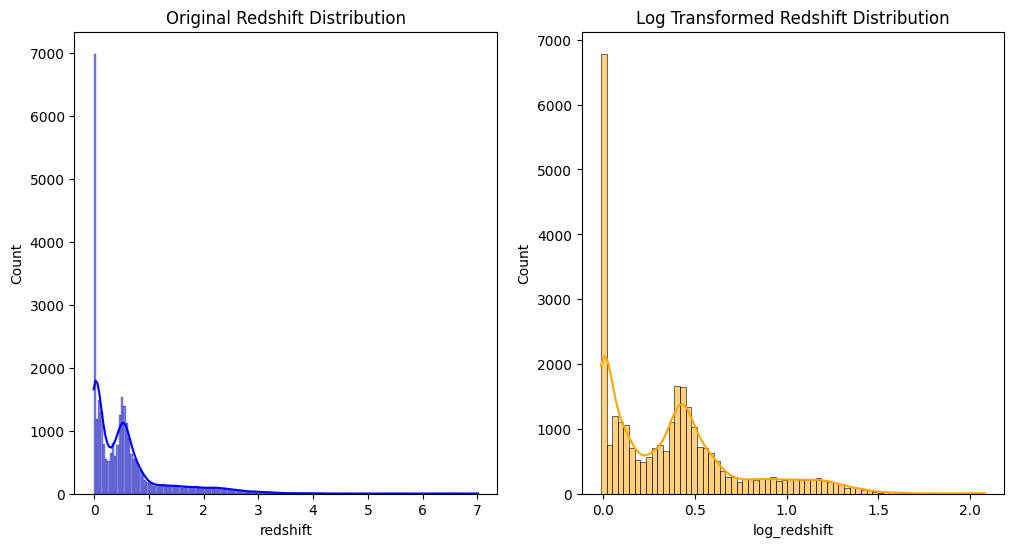

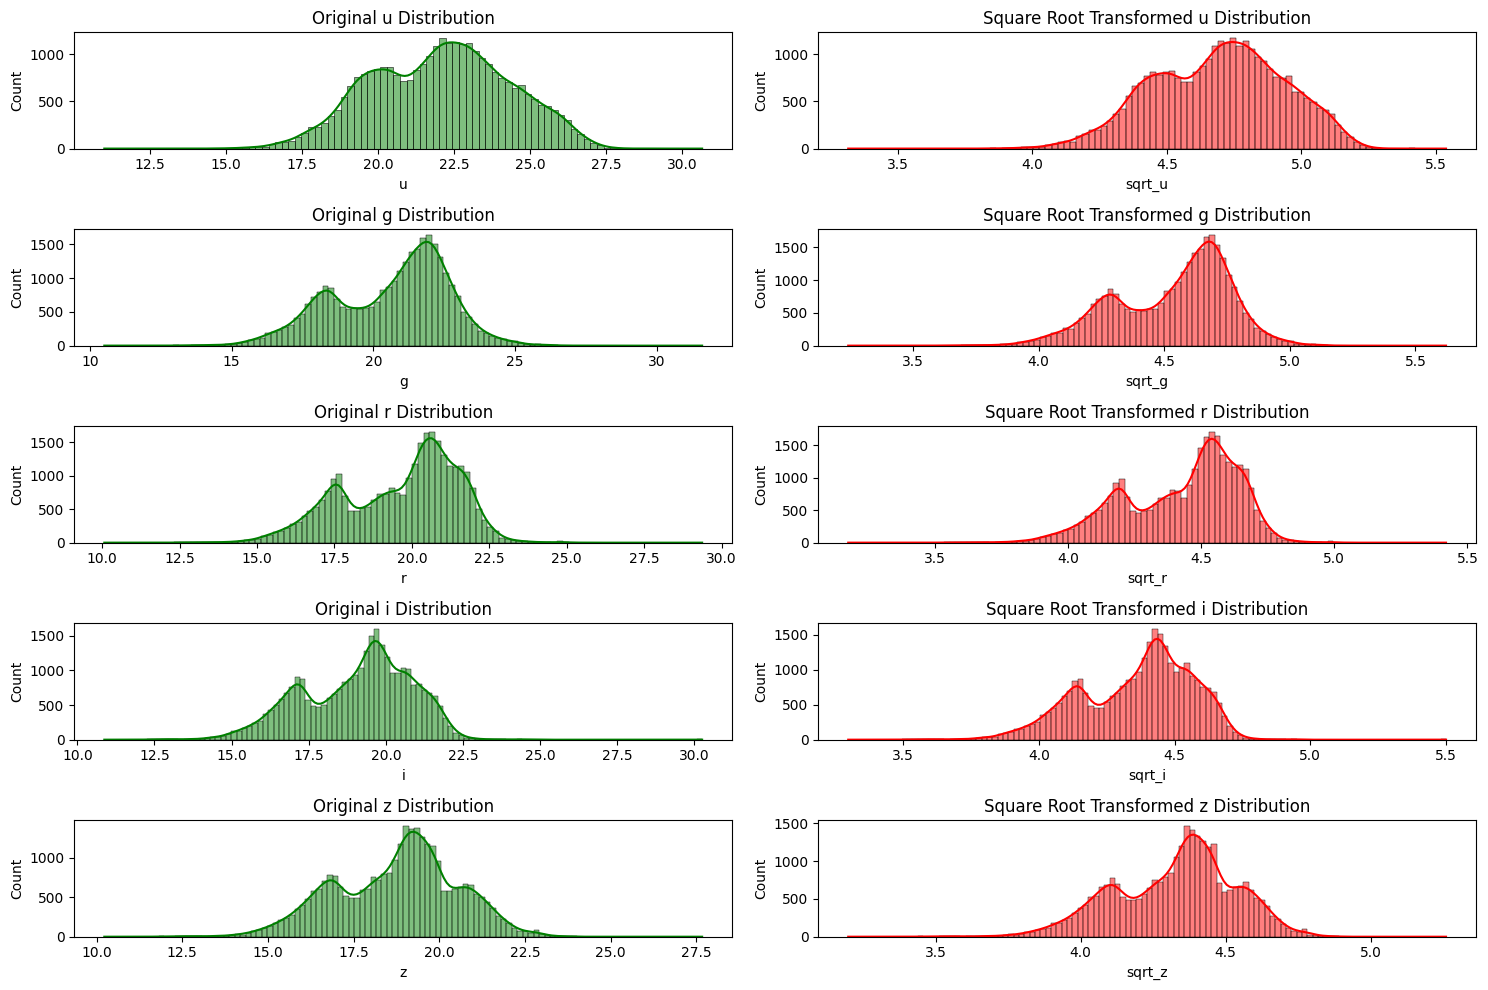

In [6]:
# Apply logarithmic transformation to the redshift column
df['log_redshift'] = np.log(df['redshift'] + 1)  

# Apply the square root transformations to the other columns as they are negatively skewed
columns_to_transform = ['u', 'g', 'r', 'i', 'z']
for col in columns_to_transform:
    df[f'sqrt_{col}'] = np.sqrt(df[col])  

# Visualise the original and transformed data for redshift
plt.figure(figsize=(12, 6))

# Original redshift
plt.subplot(1, 2, 1)
sns.histplot(df['redshift'], kde=True, color='blue')
plt.title('Original Redshift Distribution')

# Transformed redshift
plt.subplot(1, 2, 2)
sns.histplot(df['log_redshift'], kde=True, color='orange')
plt.title('Log Transformed Redshift Distribution')

plt.show()

# Visualize the original and transformed data for the other columns
plt.figure(figsize=(15, 10))

for i, col in enumerate(columns_to_transform):
    # Original columns
    plt.subplot(len(columns_to_transform), 2, i*2 + 1)
    sns.histplot(df[col], kde=True, color='green')
    plt.title(f'Original {col} Distribution')

    # Transformed columns
    plt.subplot(len(columns_to_transform), 2, i*2 + 2)
    sns.histplot(df[f'sqrt_{col}'], kde=True, color='red')
    plt.title(f'Square Root Transformed {col} Distribution')

plt.tight_layout()
plt.show()

As you can see the outliers have less significance on the data now.
This is most noticable with the redshift column.
Now lets look the categories of columns and the relevance of the columns.


In [7]:
data_types = df.dtypes

print("Data types of each column:")
print(data_types)


Data types of each column:
obj_ID          float64
alpha           float64
delta           float64
u               float64
g               float64
r               float64
i               float64
z               float64
run_ID            int64
rerun_ID          int64
cam_col           int64
field_ID          int64
spec_obj_ID     float64
class            object
redshift        float64
plate             int64
MJD               int64
fiber_ID          int64
log_redshift    float64
sqrt_u          float64
sqrt_g          float64
sqrt_r          float64
sqrt_i          float64
sqrt_z          float64
dtype: object


In [8]:
# Drop all id columns as they dont help with classification
df = df.drop(columns=df.filter(like='ID').columns)
df = df.drop(columns='MJD')
df = df.drop(columns='plate')
df = df.drop(columns='cam_col')

#for the columns that we have transformed drop their original columns 
#so keep log_redshift but get readshift
df = df.drop(columns=['u','g','r','i','z','redshift'])

data_types = df.dtypes

# Print the data types
print("Data types of each column:")
print(data_types)


Data types of each column:
alpha           float64
delta           float64
class            object
log_redshift    float64
sqrt_u          float64
sqrt_g          float64
sqrt_r          float64
sqrt_i          float64
sqrt_z          float64
dtype: object


I got rid of ID columns and the columns we no longer need as I have transformed them.

<h1>Task 2</h1>
Lets start normalizing the columns. This helps reduce bias, increase interpretability, and model performance. I standartized using z-scores as the columns are like a gaussian distribution.


In [9]:

# Initialize the scaler
scaler = StandardScaler()

filter_columns = ['sqrt_u', 'sqrt_g', 'sqrt_r', 'sqrt_i', 'sqrt_z', 'log_redshift']

# Apply z-score standardization
df[filter_columns] = scaler.fit_transform(df[filter_columns])

# Check the first few rows of the transformed columns
print(df[filter_columns].head())


     sqrt_u    sqrt_g    sqrt_r    sqrt_i    sqrt_z  log_redshift
0 -2.025319 -2.013449 -1.910412 -1.881949 -1.796922     -0.898608
1  0.712124  1.701112  1.119990  0.737644  0.711331      0.399521
2 -0.047537 -0.539792 -0.776820 -0.867709 -0.900448     -1.029803
3 -0.517518 -0.129108  0.375504  0.551328  0.696227      0.342939
4  0.165739  0.525363  0.309664  0.170862  0.142626      0.060873


<h1>Task 3</h1>
Lets now choose an evaluation measure. Ill begin with checking if the classes are balanced.

Class Distribution:
class
GALAXY    17735
STAR       6530
QSO        5735
Name: count, dtype: int64


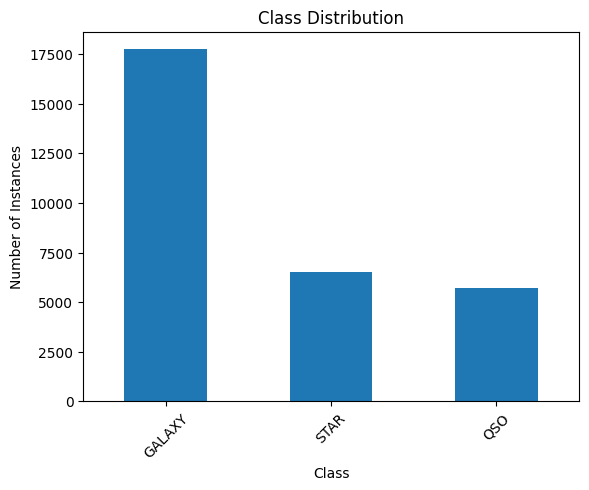

In [10]:
class_counts = df['class'].value_counts()

print("Class Distribution:")
print(class_counts)

# Plot the frequency of the class values
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Instances')
plt.xticks(rotation=45)
plt.show()

As you can see the classes are not balanced. I think f1 score will be good.

In [11]:



X = df.drop(columns=['class'])  
y = df['class']  

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a model (Random Forest)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)  # Fit the model


y_pred = model.predict(X_test)

# Classification report
report = classification_report(y_test, y_pred, output_dict=True)
print("Classification Report:")
print(report)


conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
accuracy = report['accuracy']
macro_f1 = report['macro avg']['f1-score']
weighted_f1 = report['weighted avg']['f1-score']

# Check the scores to select evaluation measure
print(f"\nEvaluation metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1 score: {macro_f1:.4f}")
print(f"Weighted F1 Score: {weighted_f1:.4f}")

Classification Report:
{'GALAXY': {'precision': 0.9755894590846047, 'recall': 0.9826767253422743, 'f1-score': 0.9791202672605791, 'support': 3579.0}, 'QSO': {'precision': 0.959280303030303, 'recall': 0.9200726612170754, 'f1-score': 0.9392675011590171, 'support': 1101.0}, 'STAR': {'precision': 0.9858103061986557, 'recall': 1.0, 'f1-score': 0.9928544565626175, 'support': 1320.0}, 'accuracy': 0.975, 'macro avg': {'precision': 0.9735600227711877, 'recall': 0.9675831288531166, 'f1-score': 0.9704140749940713, 'support': 6000.0}, 'weighted avg': {'precision': 0.9748453153137316, 'recall': 0.975, 'f1-score': 0.974828806327391, 'support': 6000.0}}
Confusion Matrix:
[[3517   43   19]
 [  88 1013    0]
 [   0    0 1320]]

Evaluation metrics:
Accuracy: 0.9750
Macro F1 score: 0.9704
Weighted F1 Score: 0.9748


As you can see f1 score is the most accurate evaluation measure.
<h1>Task 4</h1>
//Stratified K-Fold Cross-Validation

In [12]:


X = df.drop(columns=['class'])  
y = df['class']

# evaluation methodologies
methods = {
    "Train/Test Split": {
        "function": train_test_split,
        "args": [X, y],
        "kwargs": {"test_size": 0.2, "random_state": 42, "shuffle": True},
        "model": DecisionTreeClassifier(),
        "metric": f1_score,
    },
    "K-Fold": {
        "function": KFold,
        "args": [3],  # Reduced number of folds for speed
        "model": DecisionTreeClassifier(),
        "metric": f1_score,
    },
}

results = {}

for method, details in methods.items():
    start_time = time.time()
    
    if method == "Train/Test Split":
      
        X_train, X_test, y_train, y_test = details["function"](*details["args"], **details["kwargs"])
        details["model"].fit(X_train, y_train)
        predictions = details["model"].predict(X_test)
        score = details["metric"](y_test, predictions, average='macro')
    else:
        # For K-Fold
        cv = details["function"](*details["args"])
        score = cross_val_score(details["model"], X, y, cv=cv, scoring='f1_macro').mean()
    
    elapsed_time = time.time() - start_time
    results[method] = {'score': score, 'time': elapsed_time}

for method, result in results.items():
    print(f"{method}: F1 Score = {result['score']:.4f}, Time = {result['time']:.4f} seconds")

# Look for best score
best_method = max(results, key=lambda x: results[x]['score'])
print(f"\nBest Method: {best_method} with F1 Score = {results[best_method]['score']:.4f}")


Train/Test Split: F1 Score = 0.9575, Time = 0.3369 seconds
K-Fold: F1 Score = 0.9599, Time = 0.8381 seconds

Best Method: K-Fold with F1 Score = 0.9599


As you can see K-Fold has is more accurate so will we use that as the evaluation methodology.
Now lets start comparing the difference classifiers.


In [13]:
#The following code takes 20 minutes to run

print(df.head())


X = df.drop(columns=['class'])  # Features
y = df['class']  # Target variable


classifiers = {
    "Decision Tree": DecisionTreeClassifier(),
    "kNN": KNeighborsClassifier(),
    "SVM (Linear)": SVC(kernel='linear'),
    "SVM (Poly)": SVC(kernel='poly'),
    "SVM (RBF)": SVC(kernel='rbf'),
    "SVM (Sigmoid)": SVC(kernel='sigmoid')
}

# Initialise K-Fold technique
kf = KFold(n_splits=5, shuffle=True, random_state=42)


f1_scores = {name: [] for name in classifiers.keys()}

# K-Fold Cross-Validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    for name, model in classifiers.items():
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        f1 = f1_score(y_test, predictions, average='weighted')  # Use weighted F1 score
        f1_scores[name].append(f1)

# Calculate the average f1 scores
average_f1_scores = {name: np.mean(scores) for name, scores in f1_scores.items()}

# print results
for name, avg_f1 in average_f1_scores.items():
    print(f'Average F1 Score for {name}: {avg_f1:.4f}')


        alpha      delta   class  log_redshift    sqrt_u    sqrt_g    sqrt_r  \
0  167.861424   5.760343  GALAXY     -0.898608 -2.025319 -2.013449 -1.910412   
1    6.749060  12.778837  GALAXY      0.399521  0.712124  1.701112  1.119990   
2   11.431416  -0.745963    STAR     -1.029803 -0.047537 -0.539792 -0.776820   
3  235.030509  22.953851     QSO      0.342939 -0.517518 -0.129108  0.375504   
4   27.606575  -0.370674  GALAXY      0.060873  0.165739  0.525363  0.309664   

     sqrt_i    sqrt_z  
0 -1.881949 -1.796922  
1  0.737644  0.711331  
2 -0.867709 -0.900448  
3  0.551328  0.696227  
4  0.170862  0.142626  
Average F1 Score for Decision Tree: 0.9640
Average F1 Score for kNN: 0.8015
Average F1 Score for SVM (Linear): 0.9607
Average F1 Score for SVM (Poly): 0.5898
Average F1 Score for SVM (RBF): 0.4420
Average F1 Score for SVM (Sigmoid): 0.4486


Output from previous cell:
        alpha      delta   class  log_redshift    sqrt_u    sqrt_g    sqrt_r  \
0  167.861424   5.760343  GALAXY     -0.898608 -2.025319 -2.013449 -1.910412   
1    6.749060  12.778837  GALAXY      0.399521  0.712124  1.701112  1.119990   
2   11.431416  -0.745963    STAR     -1.029803 -0.047537 -0.539792 -0.776820   
3  235.030509  22.953851     QSO      0.342939 -0.517518 -0.129108  0.375504   
4   27.606575  -0.370674  GALAXY      0.060873  0.165739  0.525363  0.309664   

     sqrt_i    sqrt_z  
0 -1.881949 -1.796922  
1  0.737644  0.711331  
2 -0.867709 -0.900448  
3  0.551328  0.696227  
4  0.170862  0.142626  
Average F1 Score for Decision Tree: 0.9634 \
Average F1 Score for kNN: 0.8015\
Average F1 Score for SVM (Linear): 0.9607\
Average F1 Score for SVM (Poly): 0.5898\
Average F1 Score for SVM (RBF): 0.4420\
Average F1 Score for SVM (Sigmoid): 0.4486\

So Decision Tree was the best classifier. I am not surprised that the linear kernel perfomed better that the other kernels. This is because the data must be very lineraly seperable.

In [14]:


kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Decision tree
dt_params = {
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [1, 2]
}
dt_grid = GridSearchCV(DecisionTreeClassifier(), dt_params, cv=kf, scoring='f1_weighted', error_score='raise')
dt_grid.fit(X, y)
print("Best F1 Score for Decision Tree:", dt_grid.best_score_)
print("Best Parameters for Decision Tree:", dt_grid.best_params_)

# kNN
knn_params = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance']
}
knn_grid = GridSearchCV(KNeighborsClassifier(), knn_params, cv=kf, scoring='f1_weighted', error_score='raise')
knn_grid.fit(X, y)
print("Best F1 Score for kNN:", knn_grid.best_score_)
print("Best Parameters for kNN:", knn_grid.best_params_)


Best F1 Score for Decision Tree: 0.9719957770914999
Best Parameters for Decision Tree: {'max_depth': 7, 'min_samples_leaf': 1}
Best F1 Score for kNN: 0.8248540276542459
Best Parameters for kNN: {'n_neighbors': 3, 'weights': 'distance'}


When you use GridSearchCV for parameter tune you can get
better results with Decision Tree still being in the lead.

<h1>Task 5</h1>

In [15]:



mi_scores = mutual_info_classif(X, y, random_state=0)

# Create a DataFrame to display the scores with feature names
feature_scores = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})
feature_scores = feature_scores.sort_values(by='MI Score', ascending=False)

# Get the top and bottom 3 features
top_3_features = feature_scores['Feature'].head(3).values
bottom_3_features = feature_scores['Feature'].tail(3).values

print("Top 3 features:", top_3_features)
print("Bottom 3 features:", bottom_3_features)


Top 3 features: ['log_redshift' 'sqrt_z' 'sqrt_g']
Bottom 3 features: ['sqrt_r' 'delta' 'alpha']


In [16]:
def evaluate_svm_with_kernels(X, y, features):
    
    scaler = StandardScaler()
    X_selected = scaler.fit_transform(X[features])
    # kernels to use
    kernels = ['linear', 'poly', 'rbf', 'sigmoid']
    results = {}

    # Evaluate each SVM kernel using cross-validation
    for kernel in kernels:
        svm = SVC(kernel=kernel, random_state=0)
        scores = cross_val_score(svm, X_selected, y, cv=5, scoring='f1_macro')
        results[kernel] = scores.mean()
        print(f"Average F1 Score for SVM with {kernel} kernel: {scores.mean():.4f}")

    return results


In [17]:
#Takes seven minutes
print("Evaluating with Top 3 Features:")
top_3_results = evaluate_svm_with_kernels(X, y, top_3_features)

print("\nEvaluating with Bottom 3 Features:")
bottom_3_results = evaluate_svm_with_kernels(X, y, bottom_3_features)


Evaluating with Top 3 Features:
Average F1 Score for SVM with linear kernel: 0.9537
Average F1 Score for SVM with poly kernel: 0.9427
Average F1 Score for SVM with rbf kernel: 0.9604
Average F1 Score for SVM with sigmoid kernel: 0.7391

Evaluating with Bottom 3 Features:
Average F1 Score for SVM with linear kernel: 0.2477
Average F1 Score for SVM with poly kernel: 0.2477
Average F1 Score for SVM with rbf kernel: 0.2943
Average F1 Score for SVM with sigmoid kernel: 0.3311


Output From previous cell
Evaluating with Top 3 Features:\
Average F1 Score for SVM with linear kernel: 0.9537\
Average F1 Score for SVM with poly kernel: 0.9427\
Average F1 Score for SVM with rbf kernel: 0.9604\
Average F1 Score for SVM with sigmoid kernel: 0.7391\

Evaluating with Bottom 3 Features:\
Average F1 Score for SVM with linear kernel: 0.2477\
Average F1 Score for SVM with poly kernel: 0.2477\
Average F1 Score for SVM with rbf kernel: 0.2943\
Average F1 Score for SVM with sigmoid kernel: 0.3311

<h2>Top 3 Features</h2>
The linear, poly, rbf kernels all perfomed very well
This suggests that the features have strong discriminative power
The sigmoid kernel did not perform well

<h2>Bottom 3 Features</h2>
For the bottom three features all the kernels performed poorly
So these features dont really provide meaningful information for classification

<h1>Task 6</h1>


In [18]:

# reduce the dataset size so that it can complete in a reasonable time(3 mins)
X, y = X.sample(frac=0.1, random_state=42), y.sample(frac=0.1, random_state=42)


classifiers = {
    'Decision Tree': DecisionTreeClassifier(),
    'kNN': KNeighborsClassifier(),
    'SVM (Linear)': SVC(kernel='linear', probability=True),
    'SVM (Polynomial)': SVC(kernel='poly', probability=True),
    'SVM (RBF)': SVC(kernel='rbf', probability=True),
    'SVM (Sigmoid)': SVC(kernel='sigmoid', probability=True)
}

selected_features_dict = {}
f1_scores_dict = {}
cv_folds = 3 #cross validation folds


for name, clf in classifiers.items():
    if name == 'kNN' or 'SVM' in name and clf.kernel != 'linear':
        # Use all features for kNN and non-linear SVM variants
        y_pred = cross_val_predict(clf, X, y, cv=cv_folds, n_jobs=-1)
        f1_scores_dict[name] = f1_score(y, y_pred, average='weighted')
        selected_features_dict[name] = X.columns.tolist()  # Use all features
    else:
        # Use RFE for decision tree and SVM with linear kernel
        selector = RFE(estimator=clf, n_features_to_select=2, step=1)
        selector = selector.fit(X, y)
        # selected features
        selected_features = X.columns[selector.support_]
        selected_features_dict[name] = selected_features.tolist()


        # Calculate the f1 Score with the selected features
        y_pred = cross_val_predict(clf, X[selected_features], y, cv=cv_folds, n_jobs=-1)
        f1_scores_dict[name] = f1_score(y, y_pred, average='weighted')

#show results and scores
for name in classifiers.keys():
    print(f"Classifier: {name}")
    print(f"Selected Features: {selected_features_dict[name]}")
    print(f"Average F1 Score: {f1_scores_dict[name]:.4f}\n")

# Compare feature subsets
for name in classifiers.keys():
    print(f"Classifier: {name}")
    print(f"Wrapper Selected Features: {selected_features_dict[name]}\n")


Classifier: Decision Tree
Selected Features: ['log_redshift', 'sqrt_g']
Average F1 Score: 0.9524

Classifier: kNN
Selected Features: ['alpha', 'delta', 'log_redshift', 'sqrt_u', 'sqrt_g', 'sqrt_r', 'sqrt_i', 'sqrt_z']
Average F1 Score: 0.5952

Classifier: SVM (Linear)
Selected Features: ['log_redshift', 'sqrt_g']
Average F1 Score: 0.9472

Classifier: SVM (Polynomial)
Selected Features: ['alpha', 'delta', 'log_redshift', 'sqrt_u', 'sqrt_g', 'sqrt_r', 'sqrt_i', 'sqrt_z']
Average F1 Score: 0.4383

Classifier: SVM (RBF)
Selected Features: ['alpha', 'delta', 'log_redshift', 'sqrt_u', 'sqrt_g', 'sqrt_r', 'sqrt_i', 'sqrt_z']
Average F1 Score: 0.4383

Classifier: SVM (Sigmoid)
Selected Features: ['alpha', 'delta', 'log_redshift', 'sqrt_u', 'sqrt_g', 'sqrt_r', 'sqrt_i', 'sqrt_z']
Average F1 Score: 0.4264

Classifier: Decision Tree
Wrapper Selected Features: ['log_redshift', 'sqrt_g']

Classifier: kNN
Wrapper Selected Features: ['alpha', 'delta', 'log_redshift', 'sqrt_u', 'sqrt_g', 'sqrt_r', 'sq

Output from previous cell;
Classifier: Decision Tree
Selected Features: ['log_redshift', 'sqrt_g']
Average F1 Score: 0.9500

Classifier: kNN
Selected Features: ['alpha', 'delta', 'log_redshift', 'sqrt_u', 'sqrt_g', 'sqrt_r', 'sqrt_i', 'sqrt_z']
Average F1 Score: 0.5952

Classifier: SVM (Linear)
Selected Features: ['log_redshift', 'sqrt_g']
Average F1 Score: 0.9472

Classifier: SVM (Polynomial)
Selected Features: ['alpha', 'delta', 'log_redshift', 'sqrt_u', 'sqrt_g', 'sqrt_r', 'sqrt_i', 'sqrt_z']
Average F1 Score: 0.4383

Classifier: SVM (RBF)
Selected Features: ['alpha', 'delta', 'log_redshift', 'sqrt_u', 'sqrt_g', 'sqrt_r', 'sqrt_i', 'sqrt_z']
Average F1 Score: 0.4383

Classifier: SVM (Sigmoid)
Selected Features: ['alpha', 'delta', 'log_redshift', 'sqrt_u', 'sqrt_g', 'sqrt_r', 'sqrt_i', 'sqrt_z']
Average F1 Score: 0.4264

Classifier: Decision Tree
Wrapper Selected Features: ['log_redshift', 'sqrt_g']


Classifier: kNN
Wrapper Selected Features: ['alpha', 'delta', 'log_redshift', 'sqrt_u', 'sqrt_g', 'sqrt_r', 'sqrt_i', 'sqrt_z']


Classifier: SVM (Linear)
Wrapper Selected Features: ['log_redshift', 'sqrt_g']


Classifier: SVM (Polynomial)
Wrapper Selected Features: ['alpha', 'delta', 'log_redshift', 'sqrt_u', 'sqrt_g', 'sqrt_r', 'sqrt_i', 'sqrt_z']


Classifier: SVM (RBF)
Wrapper Selected Features: ['alpha', 'delta', 'log_redshift', 'sqrt_u', 'sqrt_g', 'sqrt_r', 'sqrt_i', 'sqrt_z']


Classifier: SVM (Sigmoid)
Wrapper Selected Features: ['alpha', 'delta', 'log_redshift', 'sqrt_u', 'sqrt_g', 'sqrt_r', 'sqrt_i', 'sqrt_z']

In task five the top 3 features were sqrt_g, log_redshift, and sqrt_z.
In task six the features selected using the two classifiers with a high f1 score are the following:
The linear svm and decision tree were able to select features successfully and had high f1 scores. The features they chose were log_redshift and sqrt_g.
The filter based approach in general was better for choosing the top features most of the classifiers had good results with the top features. In contrast with the wrapper feature selection technique where only two classifiers performed well and were able to choose the relevant features.

<h1>Task 7</h1>
Okay so regarding task 6 there was a significant decrease in the models' abilities to accurately predict new instances. I believe this was due to overfitting. I did not expect this.
In task 5 we did see some improvement ecspecially in regards to the rbf, poly and sigmoid kernel Support Vector Machines. I expected an increase in performance from the filter-based selection but not a significant increase like what we have seen here. 



<h1>Task 8</h1>

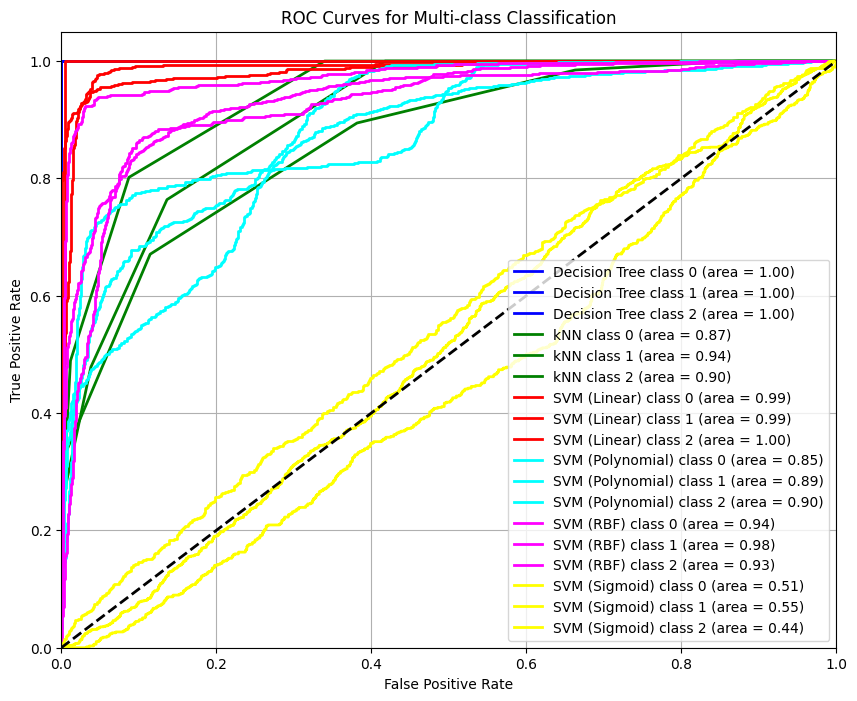

In [19]:


# Binarise the output for multi-class ROC curve
y_bin = label_binarize(y, classes=np.unique(y))
n_classes = y_bin.shape[1]
plt.figure(figsize=(10, 8))


colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow']

# Train classifier and plot the roc curves
for (name, clf), color in zip(classifiers.items(), colors):
    clf.fit(X, y)
    
    #probability scores for the ROC curves
    y_score = clf.predict_proba(X)
    
   
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        # Plot the curves
        plt.plot(fpr[i], tpr[i], color=color, lw=2, 
                 label=f'{name} class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Multi-class Classification')
plt.legend(loc="lower right")
plt.grid()
plt.show()


The decision tree is the best classifier for this task. The svm with the linear kernel also performed very well. I am satifised with the performance as the decision tree classifiers area under the curve is 1 meaning it can predict perfectly. 